# Gaussian Process

## The Core Idea

A Gaussian Process (GP) is a probability distribution over functions, where any finite set of function values follows a multivariate Gaussian distribution.

This single sentence already tells you how GPs differ from most ML models:

- Linear regression → distribution over parameters
- Neural networks → deterministic function (unless Bayesian)
- **Gaussian Process → distribution over functions**

That distinction drives everything else.

## Why Do We Need a Distribution Over Functions?

In many real problems:

- Data is sparse
- Noise is high
- Uncertainty matters more than point predictions

GPs answer:

“Given limited data, what functions are plausible, and how uncertain am I?”

This makes GPs especially strong for:

- Scientific modeling
- Bayesian optimization
- Active learning
- Small-to-medium datasets

But this same strength creates computational limits (we’ll get there).

## The Mathematical Definition (Minimal but Precise)

A Gaussian Process is defined as:

f(x)∼GP(m(x),k(x,x'))

Where:

- m(x) = mean function (often assumed 0)
- k(x,x') = covariance (kernel) function

Key insight:

- The kernel is the model.

Everything you believe about smoothness, periodicity, or similarity is encoded there

## Intuition: How a GP “Thinks”

Think of a GP as doing three things:

### Step 1: Prior over Functions

Before seeing data, the GP assumes:
- Nearby inputs should produce similar outputs (depending on kernel)
- Functions are smooth / periodic / rough (again, kernel-dependent)

This is not learned from data — it’s an assumption.

### Step 2: Observe Data

Given training data:

(X,y)

The GP conditions the prior on observed points.

### Step 3: Posterior over Functions

After conditioning:
- Mean becomes the best prediction
- Variance tells you how uncertain you are

Crucially:
- Uncertainty increases away from data — unlike most neural nets.

## Common kernels:

### 1. RBF (Squared Exponential)

Assumes:

- Infinite smoothness
- Very strong inductive bias

Great for interpolation, terrible for extrapolation.

### 2. Matérn

Controls smoothness explicitly.
Often more realistic for physical systems.

### 3. Periodic Kernel

Encodes repeating structure (seasonality, cycles).

- Critical insight:

Choosing the wrong kernel is equivalent to choosing the wrong model.

GPs don’t “discover” structure unless the kernel allows it.

## Prediction: What Comes Out?

For a new input 𝑥 , GP returns:
- Mean → prediction
- Variance → uncertainty

This uncertainty is:

- Data-dependent
- Calibrated (in theory)
- Extremely valuable for decision-making

This is why GPs dominate Bayesian Optimization.

## Computational Reality (The Hidden Cost)

GP training involves inverting n × n covariance matrix:

- Time complexity: O(n³)
- Memory: O(n²)

This is not a detail — it’s the main limitation.

Practical Consequences

- n ≲ 10,000 → already painful
- n ≳ 50,000 → infeasible without approximations

This is why:

- Sparse GPs
- Inducing points
- Variational GPs

exist at all.

## Strengths vs Trade-offs

Strengths

- Strong uncertainty estimates
- Excellent with small data
- Interpretable assumptions
- Bayesian by construction

Weaknesses

- Poor scalability
- Kernel engineering required
- Weak extrapolation
- High-dimensional inputs are hard

A GP is not “better” than deep learning — it solves a different class of problems.

## When Should You Use a Gaussian Process?

Use GPs when:

- Data is limited
- You need uncertainty
- Decisions are expensive
- Interpretability matters

Avoid GPs when:

- Millions of samples
- High-dimensional raw inputs (images, text)
- You need fast inference at scale

## Gaussian Process Regression: Step-by-Step with Equations

## 1. Problem Setup

You are given:

- Training inputs:
  
  $$
  X = \{x_1, x_2, \dots, x_n\}
  $$

- Observed targets:

  $$
  y = \{y_1, y_2, \dots, y_n\}
  $$

Goal:

> Predict the output $y_*$ for a new input $x_*$ **with uncertainty**.

Gaussian Processes (GPs) do not fit parameters like weights.  
They infer a **distribution over functions**.

---

## 2. Gaussian Process Prior

We assume the latent function follows a GP:

$$
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$$

Common simplification:

$$
m(x) = 0
$$

All modeling assumptions are encoded in the **kernel** $k(x, x')$.

---

## 3. Finite-Dimensional Representation

Evaluate the function at training points:

$$
\mathbf{f} =
\begin{bmatrix}
f(x_1) \\
\vdots \\
f(x_n)
\end{bmatrix}
$$

Then:

$$
\mathbf{f} \sim \mathcal{N}(\mathbf{0}, K)
$$

Where the covariance matrix:

$$
K_{ij} = k(x_i, x_j)
$$

Interpretation:
- Diagonal → variance at a point
- Off-diagonal → similarity between points

---

## 4. Observation Noise

Observed values include noise:

$$
y = f(x) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma_n^2)
$$

This yields:

$$
y \sim \mathcal{N}(\mathbf{0}, K + \sigma_n^2 I)
$$

Noise controls overfitting:
- $\sigma_n^2 \to 0$ → interpolation
- Large $\sigma_n^2$ → smoothing

---

## 5. Joint Distribution (Train + Test)

For a test point $x_*$ with latent value $f_*$:

$$
\begin{bmatrix}
\mathbf{y} \\
f_*
\end{bmatrix}
\sim
\mathcal{N}
\left(
\mathbf{0},
\begin{bmatrix}
K + \sigma_n^2 I & k_* \\
k_*^T & k(x_*, x_*)
\end{bmatrix}
\right)
$$

Where:

$$
k_* =
\begin{bmatrix}
k(x_1, x_*) \\
\vdots \\
k(x_n, x_*)
\end{bmatrix}
$$

---

## 6. Posterior Distribution (Prediction)

Using Gaussian conditioning:

### Posterior Mean

$$
\mu_* = k_*^T (K + \sigma_n^2 I)^{-1} y
$$

### Posterior Variance

$$
\sigma_*^2 = k(x_*, x_*) - k_*^T (K + \sigma_n^2 I)^{-1} k_*
$$

Key properties:
- Mean is similarity-weighted prediction
- Variance increases away from data
- Uncertainty is data-dependent

---

## 7. Interpretation as Kernel Regression

The posterior mean can be written as:

$$
\mu_* = \sum_{i=1}^{n} \alpha_i \, k(x_i, x_*)
$$

Where:

$$
\alpha = (K + \sigma_n^2 I)^{-1} y
$$

This resembles kernel ridge regression — but GP integrates over infinitely many functions.

---

## 8. Learning Hyperparameters

Kernel parameters and noise are learned by maximizing the log marginal likelihood:

$$
\log p(y | X) =
-\frac{1}{2} y^T (K + \sigma_n^2 I)^{-1} y
-\frac{1}{2} \log |K + \sigma_n^2 I|
-\frac{n}{2} \log 2\pi
$$

Trade-off:
- First term → data fit
- Second term → complexity penalty

This acts as an automatic Occam’s razor.

---

## 9. Computational Complexity

Matrix inversion dominates:

- Time complexity: $O(n^3)$
- Memory complexity: $O(n^2)$

This limits standard GPs to small–medium datasets.

---

## 10. Mental Model Summary

1. Place a prior over functions  
2. Encode beliefs via the kernel  
3. Observe data  
4. Condition Gaussian distributions  
5. Obtain prediction **and uncertainty** analytically  

Gaussian Process regression is **exact Bayesian inference under strong structural assumptions**, not just curve fitting.


## Gaussian Process Regression — scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [2]:
### Generate Toy Data
rng = np.random.default_rng(42)

X = np.linspace(0, 10, 20).reshape(-1, 1)
y = np.sin(X).ravel() + rng.normal(0, 0.1, size=len(X))

In [3]:
### Define Kernel (This is the Model)
kernel = (
    1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))
)

Why this matters

- RBF → smoothness assumption
- WhiteKernel → observation noise (don’t fake this with alpha)
- Bounds prevent degenerate solutions

In [4]:
### Fit Gaussian Process
gp = GaussianProcessRegressor(
    kernel=kernel,
    optimizer="fmin_l_bfgs_b",
    n_restarts_optimizer=5,
    normalize_y=True
)

gp.fit(X, y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=5, normalize_y=True)

Critical choices

- normalize_y=True stabilizes optimization
- n_restarts_optimizer avoids bad local optima

In [7]:
### Predict with Uncertainty
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

y_mean, y_std = gp.predict(X_test, return_std=True)


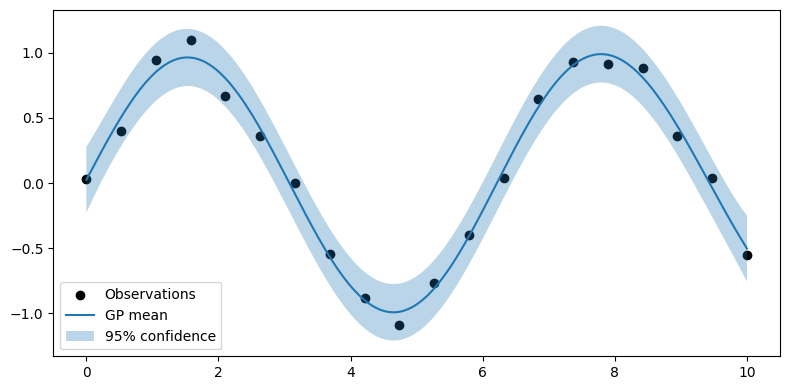

In [ ]:
    ### Plot Results
    plt.figure(figsize=(8, 4))
    plt.scatter(X, y, color="black", label="Observations")
    plt.plot(X_test, y_mean, label="GP mean")
    plt.fill_between(
        X_test.ravel(),
        y_mean - 2 * y_std,
        y_mean + 2 * y_std,
        alpha=0.3,
        label="95% confidence"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
### Inspec t Kernel Parameters
print("Learned kernel:", gp.kernel_)

Learned kernel: 1.85**2 * RBF(length_scale=2.04) + WhiteKernel(noise_level=0.0206)


## Gaussian Process Regression — Pure NumPy

This version mirrors the math exactly.
Do not use this for large datasets.

In [10]:
### Kernel Function
def rbf_kernel(X1, X2, length_scale=1.0, variance=1.0):
    sqdist = (
        np.sum(X1**2, axis=1).reshape(-1, 1)
        + np.sum(X2**2, axis=1)
        - 2 * X1 @ X2.T
    )
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

In [11]:
### GP Prediction using Custom Kernel
def gp_predict(X_train, y_train, X_test, noise=1e-6):
    K = rbf_kernel(X_train, X_train)
    K += noise * np.eye(len(X_train))  # numerical stability

    K_s = rbf_kernel(X_train, X_test)
    K_ss = rbf_kernel(X_test, X_test)

    # Cholesky decomposition (never invert directly)
    L = np.linalg.cholesky(K)

    # Solve for alpha
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

    # Posterior mean
    mu = K_s.T @ alpha

    # Posterior covariance
    v = np.linalg.solve(L, K_s)
    cov = K_ss - v.T @ v

    return mu, np.diag(cov)


In [12]:
### Run Prediction
mu, var = gp_predict(X, y, X_test, noise=1e-4)
std = np.sqrt(var)

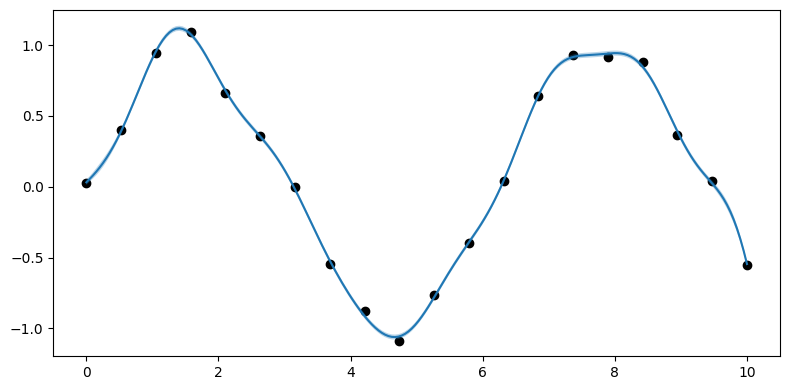

In [13]:
plt.figure(figsize=(8, 4))
plt.scatter(X, y, color="black")
plt.plot(X_test, mu)
plt.fill_between(
    X_test.ravel(),
    mu - 2 * std,
    mu + 2 * std,
    alpha=0.3
)
plt.tight_layout()
plt.show()